In [18]:
import numpy as np
from astropy.io import fits
from astropy import constants
from astropy.units import Unit


convs_fct = 1.40*10**-15 # cps -> erg s^-1 cm^-2 AA^-1
speed_of_light = (constants.c).to('cm/s').value
wavelength = 1516*Unit("Angstrom") # effective wavelength (AA) (1516 AA? 1538.6 AA?)
wavelength = wavelength.to('cm').value
convs_fct_unit = wavelength**2 / speed_of_light # f(lambda) -> f(nu)

Img_FUV = fits.open('/Users/zhangl/desktop/SINGS/GALEX/NGC5194_I_FUV_g2006.fits')
pixarea = np.abs(Img_FUV[0].header['CDELT1']*Img_FUV[0].header['CDELT2'])*(np.pi/180)**2
pix_fct = 1/pixarea
factor = convs_fct*convs_fct_unit*pix_fct*10**26 # 10^26 for erg s^-1 cm^-2 -> mJy
Img_FUV['PRIMARY'].data = Img_FUV['PRIMARY'].data*10**8*factor # 10^8 for conveting AA^-1 to cm^-1 in cgs unit
Img_FUV[0].header['BUNIT'] = 'mJy/sr'
Img_FUV.writeto('/Users/zhangl/desktop/SINGS/Img_Mon/NGC5194_FUV_flux.fits', overwrite = True)

In [19]:
import numpy as np
from astropy.io import fits
from astropy import constants
from astropy.units import Unit


Img_Ha = fits.open('/Users/zhangl/desktop/SINGS/Halpha/ngc5194_HA_SUB_dr4.fits')
pixarea = np.abs(Img_Ha[0].header['CD1_1']*Img_Ha[0].header['CD2_2'])*(np.pi/180)**2

convs_fct = 10**3*np.float(Img_Ha[0].header['PHOTFLAM']) # cps -> mJy
pix_fct = 1/pixarea
factor = convs_fct*pix_fct
Img_Ha['PRIMARY'].data = Img_Ha['PRIMARY'].data*factor
Img_Ha[0].header['BUNIT'] = 'mJy/sr'
Img_Ha.writeto('/Users/zhangl/desktop/SINGS/Img_Mon/NGC5194_Ha_flux.fits', overwrite = True)

In [1]:
import numpy as np 
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from astropy.convolution import convolve_fft
from photutils.psf.matching import resize_psf

def CircKer(image, recover_edges):
    image = image
    size_im = image.shape

    if (recover_edges == 1):
        sz = max(size_im)
        pixels_added_side = int((sz * np.sqrt(2.0) - sz)/ 2.0) + 1 
        pixels_added      = 2 * pixels_added_side
        new_image_size_x = size_im[0] + pixels_added
        new_image_size_y = size_im[1] + pixels_added

        new_image = np.zeros((new_image_size_x,new_image_size_y))
        image_one = np.zeros((new_image_size_x,new_image_size_y))

        new_image [pixels_added_side:pixels_added_side+size_im[0],pixels_added_side:pixels_added_side+size_im[1]] = image
        wh_data  = new_image != 0
        image_one[wh_data] = 1.0

        image = new_image

    size_im = len(image)
    center_pixel = int((size_im - 1) / 2)

    original_image = image

#First we mask the pixel outside the major circle contained into the image,
#since they are far away from the center an they do not contain useful information...

    xdist, ydist = np.mgrid[0:size_im, 0:size_im] - center_pixel
    distance_sq = xdist**2 + ydist**2 
############################################################################################################
    not_useful  = distance_sq > center_pixel**2
    image[not_useful] = 0
############################################################################################################

#now we rotate 180 deg te image and add it to itself, we rotate the composite 90 deg 
#and add it to itself, then 45 deg... in 10 ierations we have 16384 rotations...
    image_temp = image
    for iteration in range(14,0,-1):
        angle = float(360.0 / (2.0 ** iteration))
        rotate(image, angle, axes=(1, 0), reshape=False, output=image_temp)
        image = (image + image_temp )/2.0

    if (recover_edges == 1):
        image_temp = image_one
        for iteration in range(14,0,-1):
            angle = float(360.0 / (2.0 ** iteration))
            rotate(image_one, angle, axes=(1, 0), reshape=False, output=image_temp)
            image_one = (image_one + image_temp )/2.0

        wh = image_one > 0.1
        corrector = image_one * 0
        corrector[wh] = 1 / image_one[wh]
        image = image * corrector

    image[not_useful] = 0.0
    image /= image.sum()
    wh = np.abs(image) < 1.0e-10
    image[wh] = 0.0
    return(image)


def Ker_resize(path1, path2, img_name, ker_name):
    img_fits = fits.open(path1 + '{0}.fits'.format(img_name))
    kerf = fits.open(path2 + '{0}.fits'.format(ker_name))
    ker = kerf[0].data
    scalei = round(np.abs(kerf[0].header['CD1_1'])*3600,3)
    scaleii = round(np.abs(img_fits[0].header['CD1_1'])*3600, 3)
# just make sure not to invoke the warning "the returned array has changed.", UserWarning
    rem = round((len(ker)*(scalei/scaleii))%1,2)
    if(rem >= 0.5):
        ind = int(round(rem/((2*scalei/scaleii)%1),2))
        if(ind != 0):
            ker = ker[ind:-ind,ind:-ind]
    keri = resize_psf(ker, scalei, scaleii, order=3)
    while(len(keri)%2 == 0):
        ker = ker[1:-1,1:-1]
        rem = round((len(ker)*(scalei/scaleii))%1,2)
        if(rem >= 0.5):
            ind = int(round(rem/((2*scalei/scaleii)%1),2))
            if(ind != 0):
                ker = ker[ind:-ind,ind:-ind]
        keri = resize_psf(ker, scalei, scaleii, order=3)
    ker = CircKer(keri, 0)
    hdu = fits.PrimaryHDU(ker)
    hdu.writeto(path2 + '{0}_resize.fits'.format(ker_name), overwrite = True)
    img_fits.close()
    kerf.close()
# The dimensions do not have to be odd in all directions, unlike in the non-fft convolve function
#        size = len(ker)
#        if ((size % 2) == 0):
#            size = size + 1
#            new_ker = np.zeros((size,size))
#            new_ker[0:size-1,0:size-1] = ker
#            ker = new_ker
    return ()

if __name__ == '__main__':
    path1 = '/Users/zhangl/desktop/SINGS/Img_Mon/'
    path2 = '/Users/zhangl/desktop/SINGS/Kernel/'
    img = 'NGC5194_Ha_flux'
    ker = 'Kernel_LoRes_Moffet_02.0_to_Gauss_10'
    try:
        Ker_resize(path1, path2, img, ker)
        print('Resizing of {0} is OK!'.format(ker))
    except:
        print('Something worry happens when resizes {0}!'.format(ker))

In [26]:
import numpy as np
from astropy.io import fits

psff = '/Users/zhangl/desktop/SINGS/Kernel/AKARI/11psf.fits'
header = fits.open(psff)[0].header
Rot2 = np.arctan(header['CD2_1S']/header['CD1_1S'])
Rot2 = np.arctan(-header['CD1_2S']/header['CD2_2S'])
print(Rot2*180/np.pi)
CDELT1 = (header['CD1_1S']/np.cos(Rot2))*3600
CDELT2 = (-header['CD1_2S']/np.sin(Rot2))*3600
print(CDELT1, CDELT2)
CDELT1 = (header['CD2_1S']/np.sin(Rot2))*3600
CDELT2 = (header['CD2_2S']/np.cos(Rot2))*3600
print(CDELT1, CDELT2)

img = '/Users/zhangl/desktop/SINGS/Kernel/AKARI/1400387_001_S11_long.fits'
header = fits.open(img)[0].header
Rot2 = np.arctan(header['CD2_1S']/header['CD1_1S'])
Rot2 = np.arctan(-header['CD1_2S']/header['CD2_2S'])
CDELT1 = (header['CD1_1S']/np.cos(Rot2))*3600
CDELT2 = (-header['CD1_2S']/np.sin(Rot2))*3600
print(CDELT1, CDELT2)
CDELT1 = (header['CD2_1S']/np.sin(Rot2))*3600
CDELT2 = (header['CD2_2S']/np.cos(Rot2))*3600
print(CDELT1, CDELT2)

10.29355000000047
-2.3748986553560787 2.3819845263521042
-2.3748986553560254 2.3819845263521042
2.3748986553560876 -2.3819845263521064
2.3748986553560254 -2.381984526352106


In [20]:
import numpy as np
from astropy.io import fits
from astropy import constants
from astropy.units import Unit


Img_IRAC8 = fits.open('/Users/zhangl/desktop/SINGS/ngc5194_v7.phot.4.fits')

factor = 0.74 # correction factor for IRAC8 photometry of extended source
Img_IRAC8['PRIMARY'].data = Img_IRAC8['PRIMARY'].data*factor*10**6 # MJy -> mJy
Img_IRAC8[0].header['BUNIT'] = 'mJy/sr'
Img_IRAC8.writeto('/Users/zhangl/desktop/SINGS/Img_Mon/NGC5194_IRAC8_flux.fits', overwrite = True)

Img_MIPS24 = fits.open('/Users/zhangl/desktop/SINGS/ngc5194_mips24_crop_v5-0.fits')

Img_MIPS24['PRIMARY'].data = Img_MIPS24['PRIMARY'].data*10**6
Img_MIPS24[0].header['BUNIT'] = 'mJy/sr'
Img_MIPS24.writeto('/Users/zhangl/desktop/SINGS/Img_Mon/NGC5194_MIPS24_flux.fits', overwrite = True)

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

from astropy.io import fits
from astropy.convolution import convolve_fft

#warnings.filterwarnings('ignore')
Band_name = [['FUV','GALEX_FUV'], ['Ha','Moffet_02.0_resize'], ['IRAC8','IRAC_8.0']]
for band in Band_name:
    img_fits = fits.open('/Users/zhangl/desktop/SINGS/Img_Mon/NGC5194_{0}_flux.fits'.format(band[0]))
    img = img_fits[0].data
    psf_fits = fits.open('/Users/zhangl/desktop/SINGS/Kernel/Kernel_LoRes_{0}_to_Gauss_10.fits'.format(band[1]))
    psf = psf_fits[0].data
    img_cov = convolve_fft(img, psf, boundary = 'fill', allow_huge=True, preserve_nan=True)
    hdu = fits.PrimaryHDU(img_cov, header=img_fits[0].header)
    hdu.writeto('/Users/zhangl/desktop/SINGS/Img_Mon/NGC5194_{0}_FWHM10.fits'.format(band[0]), overwrite = True)
    print('Covolution of {0} image is OK!'.format(band[0]))

Covolution of FUV image is OK!
Covolution of Ha image is OK!
Covolution of IRAC8 image is OK!


In [77]:
def Montage_Reproject(name, O2):
    import os
    import numpy as np
    from astropy.io import fits
    from astropy.table import Table


    Band_name = ['FUV', 'Ha', 'IRAC8']

    p_file = '/Users/zhangl/desktop/SINGS/Cube/{0}/{0}_DR5_{1}_cube.fits'.format(name.strip(),O2)
    if(os.path.isfile(p_file)==False):
        print('No such path or file:{0}'.format(p_file))
    p_fits = fits.open(p_file)
    dirs = '/Users/zhangl/desktop/SINGS/Img_Mon'
    if(os.path.exists(dirs) != True):
        os.makedirs(dirs)
    for band in Band_name:
        hdr = open('{1}/{0}_hdr.txt'.format(band, dirs),'w')
        rp_file = '/Users/zhangl/desktop/SINGS/Img_Mon/NGC5194_{0}_FWHM10.fits'.format(band)
        if(os.path.isfile(rp_file)==False):
            print('No such path or file:{0}'.format(rp_file))
        hdr.write('SIMPLE  = T\nBITPIX  = -64\nNAXIS   = 2\n')
        hdr.write('NAXIS1  = {0}\n'.format(str(p_fits[0].header['NAXIS1']*2+1)))
        hdr.write('NAXIS2  = {0}\n'.format(str(p_fits[0].header['NAXIS2']*20+19)))
        hdr.write('CTYPE1  = {0}\n'.format(p_fits[0].header['CTYPE1']))
        hdr.write('CTYPE2  = {0}\n'.format(p_fits[0].header['CTYPE2']))
        hdr.write('EQUINOX  = {0}\n'.format(p_fits[0].header['EQUINOX']))
        hdr.write('CRVAL1  = {0}\n'.format(p_fits[0].header['CRVAL1']))
        hdr.write('CRVAL2  = {0}\n'.format(p_fits[0].header['CRVAL2']))
        hdr.write('CRPIX1  = {0}\n'.format(str(p_fits[0].header['CRPIX1']*2)))
        hdr.write('CRPIX2  = {0}\n'.format(str(p_fits[0].header['CRPIX2']*20)))
        hdr.write('CDELT1  = {0}\n'.format(p_fits[0].header['CDELT1']))
        hdr.write('CDELT2  = {0}\n'.format(p_fits[0].header['CDELT2']))
#        hdr.write('PC1_1  = {0}\n'.format(p_fits[0].header['PC1_1']))
#        hdr.write('PC2_1  = {0}\n'.format(p_fits[0].header['PC2_1']))
#        hdr.write('PC1_2  = {0}\n'.format(p_fits[0].header['PC1_2']))
#        hdr.write('PC2_2  = {0}\n'.format(p_fits[0].header['PC2_2']))
        Ro2_s = np.arcsin(p_fits[0].header['PC2_1']*p_fits[0].header['CDELT2']/p_fits[0].header['CDELT1'])*180/np.pi
        Ro22_s = [round(Ro2_s-(Ro2_s/np.abs(Ro2_s)-1)*180,7), round(Ro2_s*180/np.abs(Ro2_s)-Ro2_s-(Ro2_s/np.abs(Ro2_s)-1)*180,7)]
        Ro2_c = np.arccos(p_fits[0].header['PC1_1'])*180/np.pi
        Ro22_c = [round(Ro2_c,7), round(360-Ro2_c,7)]
        Ro2 = list(set(Ro22_s).intersection(Ro22_c))[0]
        hdr.write('CROTA2  = {0}\n'.format(str(Ro2)))
        hdr.write('BUNIT  = mJy_sr^-1\n')
        hdr.write('END')
        hdr.close()
        os.system('mProject -f {1} {2}/NGC5194_{0}_FWHM10Proj.fits {2}/{0}_hdr.txt'.format(band,rp_file,dirs))
#        header = fits.open(rp_file)[0].header
#        if('CDELT1' in header):
#            sr1 = np.abs(header['CDELT1'])**2
#        else:
#            sr1 = np.abs(header['CD1_1'])**2
#        sr2 = np.abs(p_fits[0].header['CDELT1'])**2
        photd = fits.open('{1}/NGC5194_{0}_FWHM10Proj.fits'.format(band, dirs), mode = 'update')
        photd[0].header['BUNIT'] = 'mJy/sr'
#        photd[0].data = photd[0].data*sr1/sr2
        photd.close()
    return

if __name__ == '__main__':

    gal_name = ['ngc5194']
    for name in gal_name:
        try:
            Montage_Reproject(name, 'LL2')
            print('Projection of {0}_iminging is OK!'.format(name.strip()))
        except:
            print('Something worry happens when reproject sample {0}!'.format(name.strip()))

Projection of ngc5194_iminging is OK!


In [78]:
def wcss(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    if('CROTA2' in hdu):
        CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
                ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
                ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    else:
        CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
                ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
                ('CRPIX2',hdu['CRPIX2']),('PC1_1',hdu['PC1_1']),('PC2_1',hdu['PC2_1']),('PC1_2',hdu['PC1_2']),
                ('PC2_2',hdu['PC2_2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_pix2world(x, y ,0)
    return [recx, recy]

def wcss3(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    if('CROTA2' in hdu):
        CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
                ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
                ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    else:
        CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
                ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
                ('CRPIX2',hdu['CRPIX2']),('PC1_1',hdu['PC1_1']),('PC2_1',hdu['PC2_1']),('PC1_2',hdu['PC1_2']),
                ('PC2_2',hdu['PC2_2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_world2pix(x, y ,0)
    return [recx, recy]

def Photo_redis(name, band):
    import os
    import numpy as np
    from astropy import wcs
    from astropy.io import fits

    aabb = '/Users/zhangl/Desktop/Montage/miniProject/underworld/ProjImg_LL2/{0}/SL2_on2_LL2.fits'.format(name)
    if(os.path.isfile(aabb)):
        cube = fits.open(aabb)
    else:
        print('No such file:{0}'.format(aabb))
    flux_header = cube[0].header
    apple = max(flux_header['NAXIS1'],flux_header['NAXIS2']) + 10
    crpixx, crpixy = flux_header['NAXIS1']//2, flux_header['NAXIS2']//2
    coor_mode = wcss(flux_header, [crpixx], [crpixy])
    crval = [[coor_mode[0][0]],[coor_mode[1][0]]]
    cube.close()

    nnmm = '/Users/zhangl/Desktop/SINGS/Img_Mon/'
    aabb = nnmm + '{0}_{1}_FWHM10Proj.fits'.format(str.upper(name), band)
    if(os.path.isfile(aabb)):
        cube = fits.open(aabb)
    else:
        print('No such file:{0}'.format(aabb))
    flux = np.transpose(cube['PRIMARY'].data, axes=(1, 0))
    flux_header = cube['PRIMARY'].header
    banana = np.full((apple, apple), np.nan)
    crpix = wcss3(flux_header, [crval[0][0]], [crval[1][0]])
    xx = int(round(crpix[0][0],0))
    yy = int(round(crpix[1][0],0))
    mm1 = max(0, xx-apple//2)
    mm2 = min(xx+apple-apple//2,flux_header['NAXIS1'])
    nn1 = max(0, yy-apple//2)
    nn2 = min(yy+apple-apple//2,flux_header['NAXIS2'])
    for ii in range(mm1,mm2):
        for jj in range(nn1,nn2):
            banana[apple//2 + ii-xx, apple//2 + jj-yy] = flux[ii, jj]
    CARD = [('NAXIS1',apple),('NAXIS2',apple),('CTYPE1',flux_header['CTYPE1']),('CTYPE2',flux_header['CTYPE2']),
            ('EQUINOX',flux_header['EQUINOX']),('CRVAL1',crval[0][0]),('CRVAL2',crval[1][0]),('CRPIX1',apple//2+1),
            ('CRPIX2',apple//2+1),('CDELT1',flux_header['CDELT1']),('CDELT2',flux_header['CDELT2']),
            ('CROTA2',flux_header['CROTA2']),('BUNIT','mJy/sr')]
    hdr = fits.Header(cards= CARD)
    banana = np.transpose(banana, axes=(1, 0))
    Img_hdu = fits.PrimaryHDU(banana, header=hdr)
    Img_hdu.writeto(nnmm + 'Slice/{0}_{1}_FWHM10Proj.fits'.format(str.upper(name), band), overwrite = True)
    cube.close()
    return

if __name__ == '__main__':

    name = 'ngc5194'
    band_list = ['FUV', 'Ha', 'IRAC8']
    for band in band_list:
        try:
            Photo_redis(name, band)
            print('{0} image is OK!'.format(band.strip()))
        except:
            print('Something worry happens when dealing with sample {0}!'.format(name.strip()))

FUV image is OK!
Ha image is OK!
IRAC8 image is OK!


In [79]:
def Bin_Phot(name, band):

    import numpy as np
    from astropy.io import fits
    from astropy.io import ascii
    from astropy.table import Table
    
    path = '/Users/zhangl/Desktop/SINGS/Img_Mon/Slice/'
    binR = ascii.read(path + '{0}_binning_output.txt'.format(name.strip()), format = 'ipac')
    cube = fits.open(path + '{0}_{1}_FWHM10Proj.fits'.format(str.upper(name.strip()), band))
    flux = np.transpose(cube['PRIMARY'].data, axes=(1, 0))

    x, y, binN = binR['X'], binR['Y'], binR['binNum']
    num = np.max(binN)
    ind = []
    photo = []
    delt = cube[0].header['CRPIX1']
    sr = delt**2*(np.pi/180)**2
    for ii in range (1,num+1):
        mask = (binN == ii)
        binRm = binR[mask]
        Img = 0
        for each in binRm:
            Img = Img + flux[each['X'], each['Y']]*sr
        ind.append(ii)
        photo.append(Img)
    Photom = Table([ind, photo], names = ('binN','flux'))
    Photom['flux'].format = '.8f'
    Photom.write(path + '{0}_{1}_photometry.tbl'.format(name.strip(), band), format='ascii.ipac', overwrite=True)
    print('Photometry of {0} {1} image is OK!'.format(name, band))
    return

if __name__ == '__main__':

    name = 'ngc5194'
    band_list = ['FUV', 'Ha', 'IRAC8']
    for band in band_list:
        try:
            Bin_Phot(name, band)
        except:
            print('Something worry happens when dealing with sample {0}!'.format(name.strip()))

Photometry of ngc5194 FUV image is OK!
Photometry of ngc5194 Ha image is OK!
Photometry of ngc5194 IRAC8 image is OK!


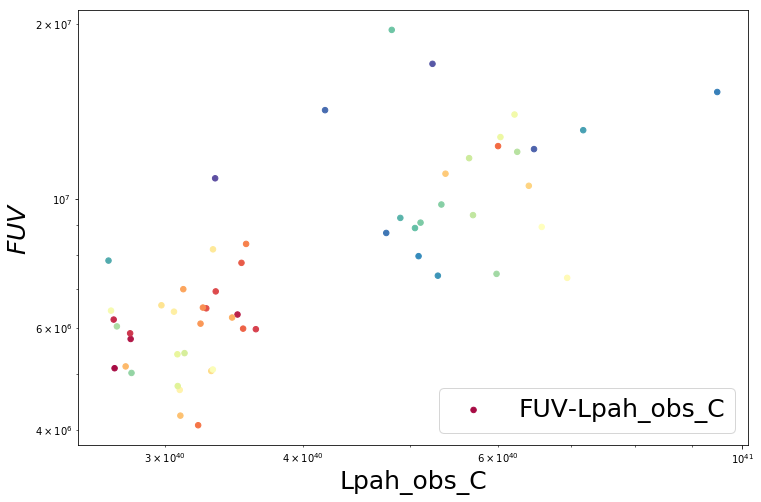

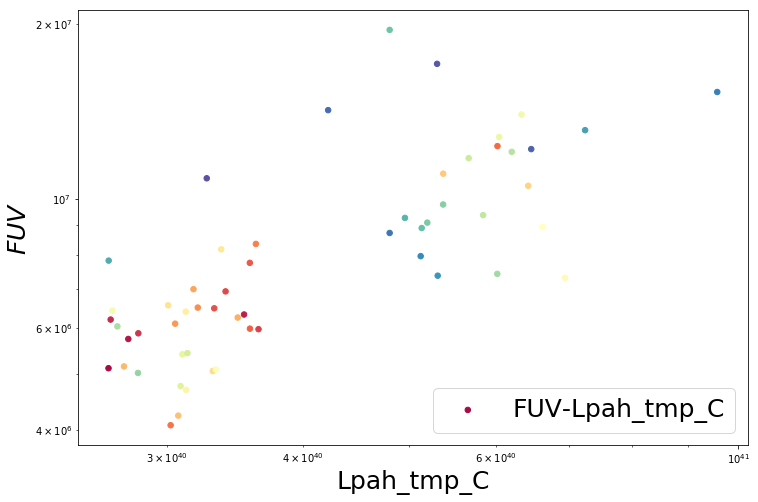

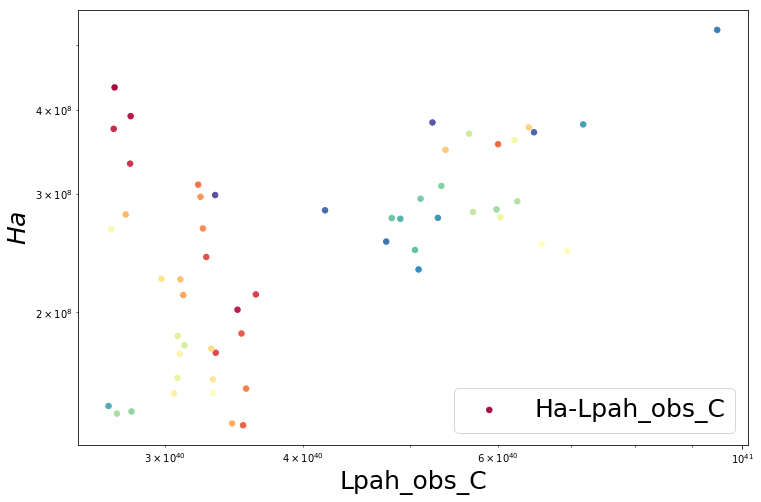

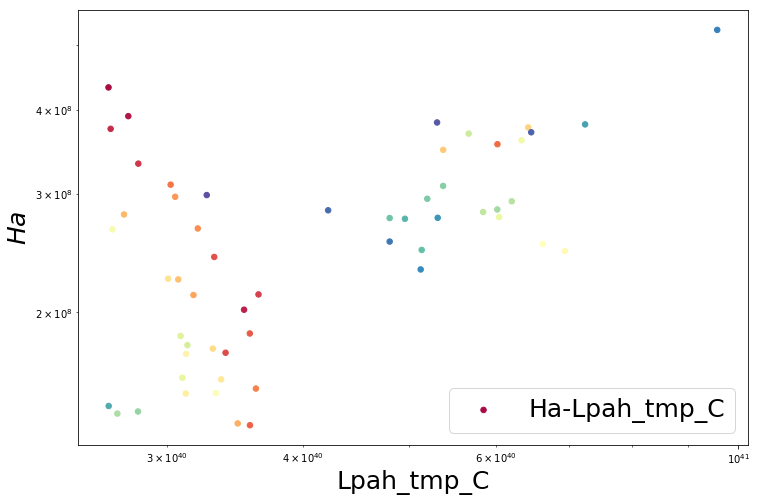

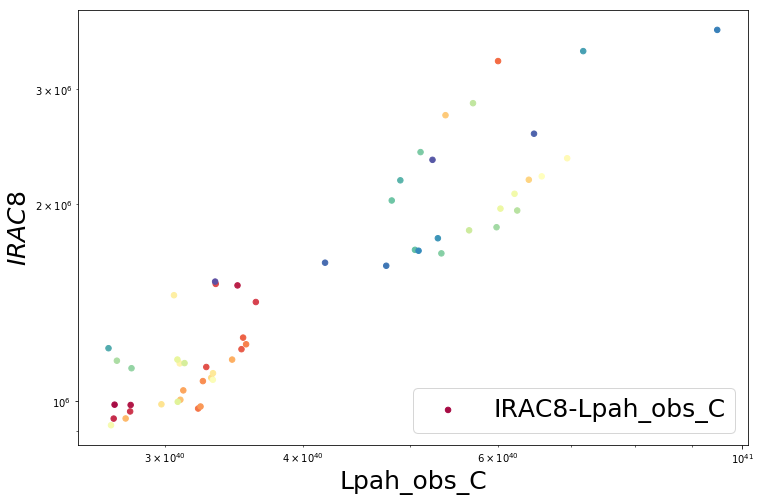

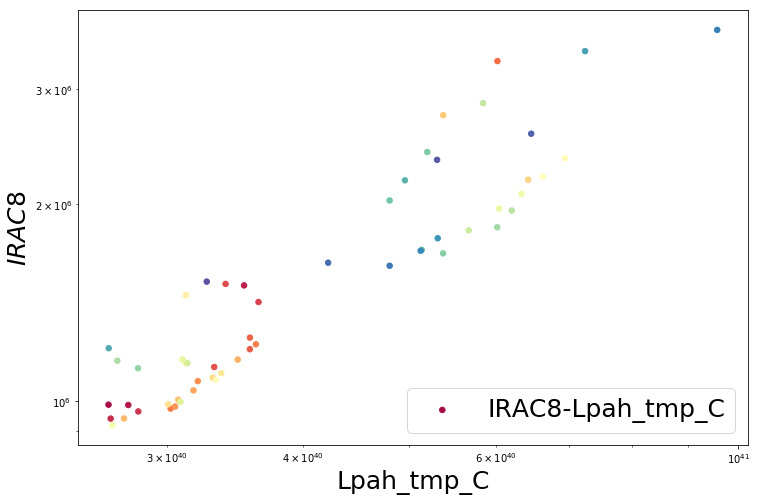

In [80]:
def Res_Plot(name, band, variable):
    import numpy as np
    from astropy.io import ascii
    import matplotlib.pyplot as plt

    f, ax = plt.subplots(1, 1, figsize=[12,8])
    path = '/Users/zhangl/Desktop/SINGS/Img_Mon/Slice/'
    fitrs = ascii.read(path + 'Res_{0}.ipac'.format(str.upper(name)), format='ipac')
    phtrs = ascii.read(path + '{0}_{1}_photometry.tbl'.format(str.lower(name), band), format='ipac')
    fitn = fitrs['Name']
    phtn = phtrs['binN']
    color = plt.cm.Spectral(np.linspace(0,1,len(fitn)+1))
    ff = []
    pp = []
    for ii in range(0,len(fitn)):
        ma1 = (fitn == '{0}_bin_{1}'.format(str.upper(name), ii+1))
        dataf = fitrs[ma1]
        ma2 = (phtn == ii+1)
        datap = phtrs[ma2]
        ff.append(dataf[variable])
        pp.append(datap['flux'])
    ff = np.array(ff)
    pp = np.array(pp)
    Vari = ax.scatter(ff, pp, c=color[1:], cmap='Spectral', s=30, label='{0}-{1}'.format(band, variable))
#    ax.set_xlim(10,0)
#    ax.set_ylim(-0.3,0.3)
#    cbar = f.colorbar(Vari)
#    cbar.ax.set_ylabel('$binN $',fontsize=25)
    ax.set_xlabel('{0}'.format(variable), fontsize=25)
    ax.set_ylabel('${0}$'.format(band), fontsize=25)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc=4, fontsize=25)
#    ax.grid(True)
    plt.show()

if __name__ == '__main__':

    name = 'ngc5194'
    band_list = ['FUV', 'Ha', 'IRAC8']
    for band in band_list:
        try:
            Res_Plot(name, band, 'Lpah_obs_C')
            Res_Plot(name, band, 'Lpah_tmp_C')
        except:
            print('Something goes worry about {0} {1} data!'.format(name, band))

In [16]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from photutils.psf.matching import resize_psf
from sympy import *

def Cal_FWHM(mode, pixsi, pixsz, name, colors, ii):
    nm1 = name.split('.')[0]
    nm2 = name.split('.')[1]
    path = '/Users/zhangl/desktop/SINGS/Kernel/G_Aniano_Kernels/PSF/'
    Imgpsf = fits.open(path + '{0}_PSFnosamp/{1}_{2}.fits'.format(mode[0:2], nm1, nm2))
    psf = Imgpsf[0].data
    header = Imgpsf[0].header
#################################################################################
# Following code is for nonsampled PSF
#    psf = resize_psf(psf, round(pixsi, 3), round(pixsz, 3), order=3)
#    header['PIXSCALX'] = header['PIXSCALX']*pixsz/pixsi
#    header['PIXSCALY'] = header['PIXSCALY']*pixsz/pixsi
#    x_size_old = header['NAXIS1']
#    y_size_old = header['NAXIS2']
#    size_new = max(x_size_old , y_size_old)
#    if ((size_new % 2) == 0):
#        size_new = size_new+ 1
#        new_psf = np.zeros((size_new,size_new))
#        new_psf[0:x_size_old,0:y_size_old] = psf
#        psf = new_psf
#        header['NAXIS1'] = size_new
#        header['NAXIS2'] = size_new
#        header['CRPIX1'] = (size_new - 1.0) / 2.0 
#        header['CRPIX2'] = (size_new - 1.0) / 2.0
#################################################################################
    cen = np.where(psf == np.max(psf))
    cen_psf = psf[cen[0][0]]
    xx = np.linspace(0,len(cen_psf)-1,len(cen_psf))-cen[0][0]
    xx = xx*pixsz
    ax[num].plot(xx, cen_psf, c = colors[ii])
    mm = np.max(cen_psf)
    ma1 = xx>0
    ma2 = cen_psf>0.25*mm
    ma3 = cen_psf<0.75*mm
    mask = ma1*ma2*ma3
    f_psf = np.polyfit(xx[mask],cen_psf[mask],1)
#    f_p  = np.poly1d(c_psf)
#    yy = f_p(xx[mask])
#    plt.plot(xx[mask],yy)
    x = symbols('x')
    FWHM = solve(f_psf[0]*x+f_psf[1]-mm/2, x)[0]*2
    header['FWHM'] = (float(FWHM), 'Arcsec')
    Imgpsf.close()
    hdu = fits.PrimaryHDU(psf, header)
    hdu.writeto(path +'{0}_PSFsam/{1}_{2}.fits'.format(mode[0:2], nm1, nm2), overwrite = True)
    return(float(FWHM))

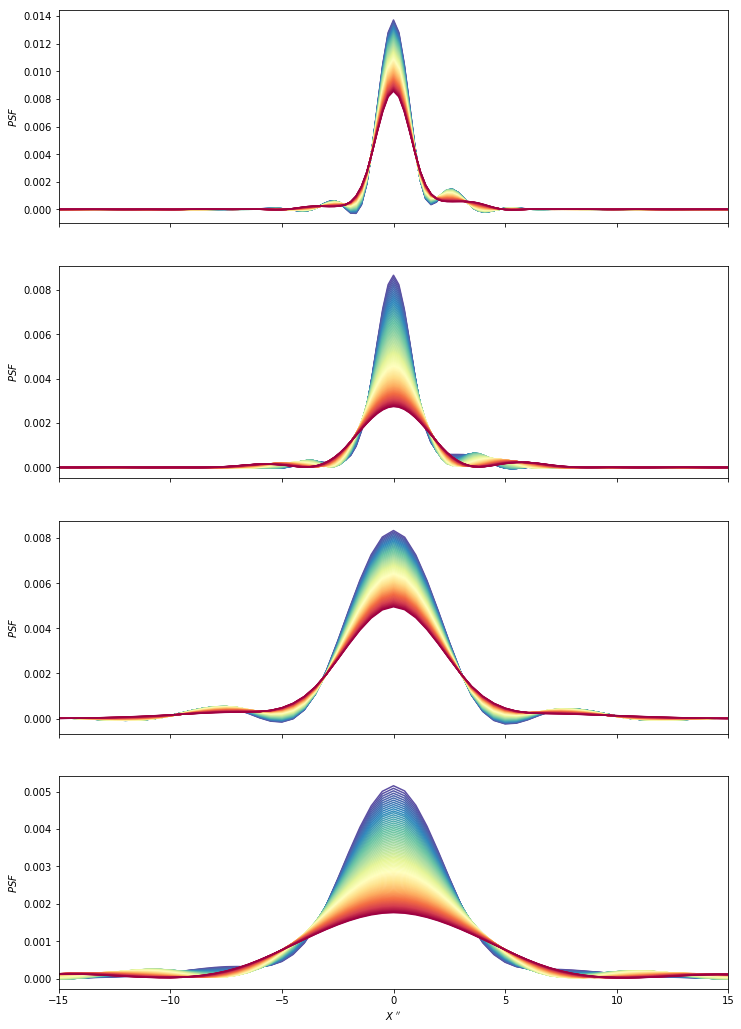

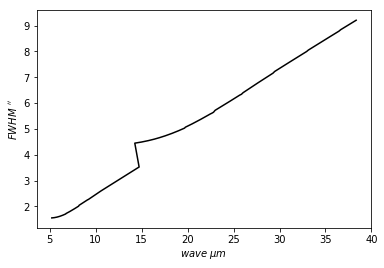

In [17]:
mode_list = [['SL2',1.2,1.2/5], ['SL1',1.2,1.2/5], ['LL2',3.5,3.5/7], ['LL1',3.5,3.5/7]]
fig, ax = plt.subplots(4, 1, sharex = True, figsize=(12,18))
FWHM = []
wave = []
for num in range(0, len(mode_list)):
    wavef = open('/Users/zhangl/desktop/SINGS/Kernel/G_Aniano_Kernels/Wave/{0}_wavelength.txt'.format(mode_list[num][0]))
    wavel = wavef.readlines()
    colors = plt.cm.Spectral(np.linspace(0,1,len(wavel)))
    for ii in range(0, len(wavel)):
        FWHMM = Cal_FWHM(mode_list[num][0], mode_list[num][1], mode_list[num][2], wavel[ii].strip(), colors, len(wavel)-ii-1)
        FWHM.append(FWHMM)
        wave.append(float(wavel[ii].strip()))
        ax[num].set_ylabel('$PSF$')
ax[3].set_xlabel('$X\ \'\'$')
ax[3].set_xlim(-15,15)
plt.show()
plt.figure()
plt.plot(wave, FWHM, 'k')
plt.xlabel('$wave\ \\mu m$')
plt.ylabel('$FWHM\ \'\'$')
plt.show()

In [56]:
from astropy.io import ascii

haha = []
for ii in range(0, len(wave)):
    haha.append([wave[ii], FWHM[ii]])
haha = sorted(haha, key=lambda x:x[0])
lala = [[],[]]
for ii in range(0, len(wave)):
    lala[0].append(haha[ii][0])
    lala[1].append(haha[ii][1])
ascii.write([lala[0], lala[1], non_axi] 'wave_FWHM.txt', names=['wave', 'FWHM', 'g'], format = 'ipac', overwrite = True)

In [1]:
import numpy as np 
from astropy.io import fits
from scipy.ndimage import rotate

def Circularization(path, mode, name, recover_edges, path1, path2):
    nm1 = name.split('.')[0]
    nm2 = name.split('.')[1]
    Img  = fits.open(path + '{0}_{3}/{1}_{2}.fits'.format(mode[0:2], nm1, nm2, path1))
    image = Img[0].data
    header = Img[0].header
    size_im = image.shape

    if (recover_edges == 1):
        sz = max(size_im)
        pixels_added_side = int((sz * np.sqrt(2.0) - sz)/ 2.0) + 1 
        pixels_added      = 2 * pixels_added_side
        new_image_size_x = size_im[0] + pixels_added
        new_image_size_y = size_im[1] + pixels_added

        new_image = np.zeros((new_image_size_x,new_image_size_y))
        image_one = np.zeros((new_image_size_x,new_image_size_y))

        new_image [pixels_added_side:pixels_added_side+size_im[0],pixels_added_side:pixels_added_side+size_im[1]] = image
        wh_data  = new_image != 0
        image_one[wh_data] = 1.0

        image = new_image
        header['CRPIX1']=(new_image_size_x-1)/2
        header['CRPIX2']=(new_image_size_y-1)/2
        header['NAXIS1']=new_image_size_x
        header['NAXIS2']=new_image_size_y

    size_im = len(image)
    center_pixel = int((size_im - 1) / 2)

    original_image = image

#First we mask the pixel outside the major circle contained into the image,
#since they are far away from the center an they do not contain useful information...

    xdist, ydist = np.mgrid[0:size_im, 0:size_im] - center_pixel
    distance_sq = xdist**2 + ydist**2 
############################################################################################################
    not_useful  = distance_sq > center_pixel**2
    image[not_useful] = 0
############################################################################################################

#now we rotate 180 deg te image and add it to itself, we rotate the composite 90 deg 
#and add it to itself, then 45 deg... in 10 ierations we have 16384 rotations...
    image_temp = image
    for iteration in range(14,0,-1):
        angle = float(360.0 / (2.0 ** iteration))
        rotate(image, angle, axes=(1, 0), reshape=False, output=image_temp)
        image = (image + image_temp )/2.0

    if (recover_edges == 1):
        image_temp = image_one
        for iteration in range(14,0,-1):
            angle = float(360.0 / (2.0 ** iteration))
            rotate(image_one, angle, axes=(1, 0), reshape=False, output=image_temp)
            image_one = (image_one + image_temp )/2.0

        wh = image_one > 0.1
        corrector = image_one * 0
        corrector[wh] = 1 / image_one[wh]
        image = image * corrector

    image[not_useful] = 0.0
    image /= image.sum()
    wh = np.abs(image) < 1.0e-10
    image[wh] = 0.0

    hdu = fits.PrimaryHDU(image,header)
    hdu.writeto(path + '{0}_{3}/{1}_{2}.fits'.format(mode[0:2], nm1, nm2, path2), overwrite = True)   

    difference = original_image - image
    difference[wh] = 0.0
    non_axi = np.abs(difference).sum() / np.abs(image).sum()
#print('------------------------------------------------------------------------------')
#print('The anisotropy parameter g of this circlularization is {0}'.format(str(round(non_axi,4))))
#print('The test was succesfully circularized!')
#print('------------------------------------------------------------------------------')
    return(non_axi)

In [2]:
mode_list = ['SL2', 'SL1', 'LL2', 'LL1']
#non_axi = []
path = '/Users/zhangl/desktop/SINGS/Kernel/G_Aniano_Kernels/PSFsam/'
for mode in mode_list:
    wavef = open('/Users/zhangl/desktop/SINGS/Kernel/G_Aniano_Kernels/Wave/{0}_wavelength.txt'.format(mode))
    wavel = wavef.readlines()
    for one in wavel:
        try:
            n_axi = Circularization(path, mode, one.strip(), 0, 'PSFsamp', 'PSFcirc')
#            non_axi.append(n_axi)
        except:
            print('Something worry happens when dealing with slice at wavelength {0}!'.format(one.strip()))

In [4]:
import numpy as np
from astropy.io import fits
from numpy.fft import fft2, fftshift
from astropy.modeling.models import Gaussian2D
from photutils import create_matching_kernel, SplitCosineBellWindow
import matplotlib.pyplot as plt

def PSF_matching(path, mode, name, FWHM, path1, path2):
    nm1 = name.split('.')[0]
    nm2 = name.split('.')[1]
    Img  = fits.open(path + '{0}_{3}/{1}_{2}.fits'.format(mode[0:2], nm1, nm2, path1))
    psf = Img[0].data
    header = Img[0].header
    size_im = psf.shape
    scale = round(header['PIXSCALX'], 3)
    sigma = FWHM/(2*np.sqrt(2*np.log(2)))
    y, x = np.mgrid[0:round(size_im[0]*scale,3):scale, 0:round(size_im[0]*scale,3):scale] - round(scale*(size_im[0]-1)/2, 3)
    gm = Gaussian2D(100, 0, 0, sigma, sigma)
    gs = gm(x, y)
    gs /= gs.sum()
#    size_im = len(x)
#    center_pixel = int((size_im - 1) / 2)
#    xdist, ydist = np.mgrid[0:size_im, 0:size_im] - center_pixel
#    distance_sq = xdist**2 + ydist**2 
#    not_useful  = distance_sq > center_pixel**2
#    gs[not_useful] = 0
    
    ftg1 = np.abs(np.real(fftshift(fft2(psf))))
    mask = ftg1 < 5*10**-3*np.max(ftg1)
    dist = np.sqrt(x**2 + y**2)
    kha = np.min(dist[mask])/scale
    alpha = 0.3*kha/((len(psf)-1)/2)
    beta = 0.7*kha/((len(psf)-1)/2)
    window = SplitCosineBellWindow(alpha, beta)
    kernel = create_matching_kernel(psf, gs, window=window)
    hdu = fits.PrimaryHDU(kernel, header)
    hdu.writeto(path + '{0}_{3}/{1}_{2}.fits'.format(mode[0:2], nm1, nm2, path2), overwrite = True)
    return(kha)

In [10]:
mode_list = ['SL2', 'SL1', 'LL2', 'LL1']
path = '/Users/zhangl/desktop/SINGS/Kernel/G_Aniano_Kernels/PSFsam/'
#kha = []
#non_axii = []
for mode in mode_list:
    wavef = open('/Users/zhangl/desktop/SINGS/Kernel/G_Aniano_Kernels/Wave/{0}_wavelength.txt'.format(mode))
    wavel = wavef.readlines()
    for one in wavel:
        try:
            khaa = PSF_matching(path, mode, one.strip(), 10, 'PSFcirc', 'ker2ten')
            n_axii = Circularization(path, mode, one.strip(), 0, 'ker2ten', 'kercirc')
#            kha.append(khaa)
#            non_axii.append(n_axii)
        except:
            print('Something worry happens when dealing with slice at wavelength {0}!'.format(one.strip()))

In [11]:
import numpy as np 
from astropy.io import fits
from scipy.ndimage import rotate

def CircKer(image, recover_edges):
    image = image
    size_im = image.shape

    if (recover_edges == 1):
        sz = max(size_im)
        pixels_added_side = int((sz * np.sqrt(2.0) - sz)/ 2.0) + 1 
        pixels_added      = 2 * pixels_added_side
        new_image_size_x = size_im[0] + pixels_added
        new_image_size_y = size_im[1] + pixels_added

        new_image = np.zeros((new_image_size_x,new_image_size_y))
        image_one = np.zeros((new_image_size_x,new_image_size_y))

        new_image [pixels_added_side:pixels_added_side+size_im[0],pixels_added_side:pixels_added_side+size_im[1]] = image
        wh_data  = new_image != 0
        image_one[wh_data] = 1.0

        image = new_image

    size_im = len(image)
    center_pixel = int((size_im - 1) / 2)

    original_image = image

#First we mask the pixel outside the major circle contained into the image,
#since they are far away from the center an they do not contain useful information...

    xdist, ydist = np.mgrid[0:size_im, 0:size_im] - center_pixel
    distance_sq = xdist**2 + ydist**2 
############################################################################################################
    not_useful  = distance_sq > center_pixel**2
    image[not_useful] = 0
############################################################################################################

#now we rotate 180 deg te image and add it to itself, we rotate the composite 90 deg 
#and add it to itself, then 45 deg... in 10 ierations we have 16384 rotations...
    image_temp = image
    for iteration in range(14,0,-1):
        angle = float(360.0 / (2.0 ** iteration))
        rotate(image, angle, axes=(1, 0), reshape=False, output=image_temp)
        image = (image + image_temp )/2.0

    if (recover_edges == 1):
        image_temp = image_one
        for iteration in range(14,0,-1):
            angle = float(360.0 / (2.0 ** iteration))
            rotate(image_one, angle, axes=(1, 0), reshape=False, output=image_temp)
            image_one = (image_one + image_temp )/2.0

        wh = image_one > 0.1
        corrector = image_one * 0
        corrector[wh] = 1 / image_one[wh]
        image = image * corrector

    image[not_useful] = 0.0
    image /= image.sum()
    wh = np.abs(image) < 1.0e-10
    image[wh] = 0.0
    return(image)

In [12]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.convolution import convolve_fft
from photutils.psf.matching import resize_psf

def Ker_resize(path, samfile, tagtfits, mode, pathker, pathkerf):
    wavef = open(samfile)
    wavel = wavef.readlines()
    img_fits = fits.open(tagtfits)
    for ii in range(0, len(wavel)):
        wave = wavel[ii].strip()
        nm1 = wave.split('.')[0]
        nm2 = wave.split('.')[1]
        kerf = fits.open(path + '{0}_{3}/{1}_{2}.fits'.format(mode[0:2], nm1, nm2, pathker))
        ker = kerf[0].data
        scalei = round(kerf[0].header['PIXSCALX'],3)
        scaleii = round(np.abs(img_fits[0].header['CDELT1'])*3600, 3)
        if(mode[0:2] == 'SL'):
            ker = ker[4:-4,4:-4]
# just make sure not to invoke the warning "the returned array has changed.", UserWarning
        rem = round((len(ker)*(scalei/scaleii))%1,2)
        if(rem >= 0.5):
            ind = int(round(rem/((2*scalei/scaleii)%1),2))
            if(ind != 0):
                ker = ker[ind:-ind,ind:-ind]
        ker = resize_psf(ker, scalei, scaleii, order=3)
        ker = CircKer(ker, 0)
        hdu = fits.PrimaryHDU(ker)
        hdu.writeto(path + '{0}_{3}/{1}_{2}.fits'.format(mode[0:2], nm1, nm2, pathkerf), overwrite = True)
        img_fits.close()
# The dimensions do not have to be odd in all directions, unlike in the non-fft convolve function
#        size = len(ker)
#        if ((size % 2) == 0):
#            size = size + 1
#            new_ker = np.zeros((size,size))
#            new_ker[0:size-1,0:size-1] = ker
#            ker = new_ker
    return ()

In [13]:
mode_list = ['SL2', 'SL1', 'LL2', 'LL1']
path = '/Users/zhangl/desktop/SINGS/Kernel/G_Aniano_Kernels/PSFsam/'
target = 'ngc5194'
for mode in mode_list:
    samfile = '/Users/zhangl/desktop/SINGS/Kernel/G_Aniano_Kernels/Wave/{0}_wavelength.txt'.format(mode)
    tagtfits = '/Users/zhangl/desktop/SINGS/Cube/{0}/{0}_DR5_{1}_cube.fits'.format(target, mode)
    try:
        Ker_resize(path, samfile, tagtfits, mode, 'kercirc', 'ker4conv')
    except:
        print('Something worry happens when dealing with {0} data!'.format(mode))

In [59]:
import numpy as np
from astropy.io import fits
from astropy.convolution import convolve_fft

def Convolve(path, samfile, tagtfits, target, mode, dtype):
    wavef = open(samfile)
    wavel = wavef.readlines()
    img_fits = fits.open(tagtfits)
    img = img_fits[0].data
    img_conv = []
    for ii in range(0, len(wavel)):
        slice_Img = img[ii]
        wave = wavel[ii].strip()
        nm1 = wave.split('.')[0]
        nm2 = wave.split('.')[1]
        kerf = fits.open(path + '{0}_ker4conv/{1}_{2}.fits'.format(mode[0:2], nm1, nm2))
        ker = kerf[0].data
        img_cov = convolve_fft(slice_Img, ker, boundary = 'fill', allow_huge=True, preserve_nan=True)
        img_conv.append(list(img_cov))
    hdu = fits.PrimaryHDU(img_conv, header=img_fits[0].header)
    hdu.writeto(path + '{0}_{1}_{2}.fits'.format(target, mode, dtype), overwrite = True)
    print('Covolution of {0} image is OK!'.format(mode))
    return()

In [15]:
mode_list = ['SL2', 'SL1', 'LL2', 'LL1']
path = '/Users/zhangl/desktop/SINGS/Kernel/G_Aniano_Kernels/PSFsam/'
target = 'ngc5194'
for mode in mode_list:
    samfile = '/Users/zhangl/desktop/SINGS/Kernel/G_Aniano_Kernels/Wave/{0}_wavelength.txt'.format(mode)
    tagtfits1 = '/Users/zhangl/desktop/SINGS/Cube/{0}/{0}_DR5_{1}_cube.fits'.format(target, mode)
    tagtfits2 = '/Users/zhangl/desktop/SINGS/Cube/{0}/{0}_DR5_{1}_cube_unc.fits'.format(target, mode)
    try:
        Convolve(path, samfile, tagtfits1, target, mode, 'convolved')
        Convolve(path, samfile, tagtfits2, target, mode, 'unc_convolved')
    except:
        print('Something worry happens when dealing with {0} data!'.format(mode))

Covolution of SL2 image is OK!
Covolution of SL2 image is OK!
Covolution of SL1 image is OK!
Covolution of SL1 image is OK!
Covolution of LL2 image is OK!
Covolution of LL2 image is OK!
Covolution of LL1 image is OK!
Covolution of LL1 image is OK!


In [60]:
mode_list = ['LL2']
path = '/Users/zhangl/desktop/SINGS/Kernel/G_Aniano_Kernels/PSFsam/'
target = 'ngc1097'
for mode in mode_list:
    samfile = '/Users/zhangl/desktop/SINGS/Kernel/G_Aniano_Kernels/Wave/{0}_wavelength.txt'.format(mode)
    tagtfits1 = '/Users/zhangl/desktop/SINGS/Cube/{0}/{0}_DR5_{1}_cube.fits'.format(target, mode)
    try:
        Convolve(path, samfile, tagtfits1, target, mode, 'convolved')
    except:
        print('Something worry happens when dealing with {0} data!'.format(mode))

Covolution of LL2 image is OK!


In [17]:
from astropy.io import fits

mode_list = ['SL2', 'SL1', 'LL2', 'LL1']
path = '/Users/zhangl/desktop/SINGS/Kernel/G_Aniano_Kernels/PSFsam/'
target = 'ngc5194'
for mode in mode_list:
    tagtfits = '/Users/zhangl/desktop/SINGS/Cube/{0}/{0}_DR5_{1}_cube.fits'.format(target, mode)
    wave = fits.open(tagtfits)[1]
    ctrg1 = path + '*{0}_{1}_{2}.fits'.format(target, mode, 'convolved')
    ctrg2 = path + '*{0}_{1}_{2}.fits'.format(target, mode, 'unc_convolved')
    spec1 = fits.open(ctrg1)[0]
    spec2 = fits.open(ctrg2)[0]
    hdul1 = fits.HDUList([spec1,wave])
    hdul2 = fits.HDUList([spec2,wave])
    hdul1.writeto(path + '{0}_{1}_{2}.fits'.format(target, mode, 'convolved'), overwrite=True)
    hdul2.writeto(path + '{0}_{1}_{2}.fits'.format(target, mode, 'unc_convolved'), overwrite=True)

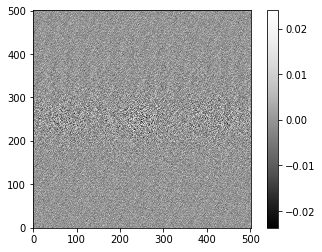

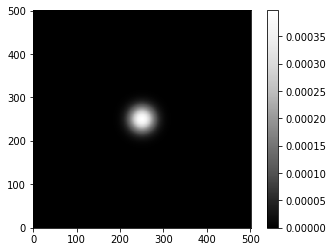

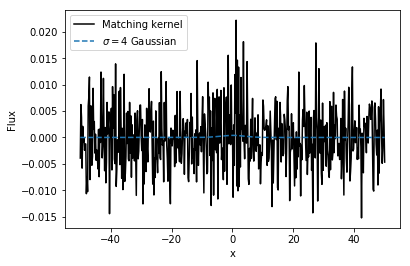

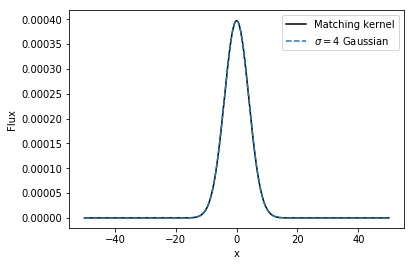

In [14]:
import numpy as np
from astropy.io import fits
from numpy.fft import fft2, fftshift
from astropy.modeling.models import Gaussian2D
from photutils import create_matching_kernel, SplitCosineBellWindow
import matplotlib.pyplot as plt

y, x = np.mgrid[0:100.2:0.2, 0:100.2:0.2,] - 50
scale = 0.2
sigma1 = 3
sigma2 = 4
sigma3 = 5
gm1 = Gaussian2D(100, 0, 0, sigma1, sigma1)
gs1 = gm1(x, y)
gs1 /= gs1.sum()
gm2 = Gaussian2D(100, 0, 0, sigma2, sigma2)
gs2 = gm2(x, y)
gs2 /= gs2.sum()
gm3 = Gaussian2D(100, 0, 0, sigma3, sigma3)
gs3 = gm3(x, y)
gs3 /= gs3.sum()

kerneltt = create_matching_kernel(gs1, gs3)
ftg1 = np.abs(np.real(fftshift(fft2(gs1))))
mask = ftg1 < 5*10**-3*np.max(ftg1)
dist = np.sqrt(x**2 + y**2)
kha = np.min(dist[mask])/scale
alpha = 0.3*kha/((len(gs1)-1)/2)
beta = 0.7*kha/((len(gs1)-1)/2)
window = SplitCosineBellWindow(alpha, beta)
kernel = create_matching_kernel(gs1, gs3, window=window)
plt.imshow(kerneltt, cmap='Greys_r', origin='lower')
plt.colorbar()
plt.show()
plt.imshow(kernel, cmap='Greys_r', origin='lower')
plt.colorbar()
plt.show()
plt.plot(x[250], kerneltt[250], 'k', label='Matching kernel')
plt.plot(x[250], gs2[250], '--', label='$\sigma=4$ Gaussian')
plt.xlabel('x')
plt.ylabel('Flux')
plt.legend()
plt.show()
plt.plot(x[250], kernel[250], 'k', label='Matching kernel')
plt.plot(x[250], gs2[250], '--', label='$\sigma=4$ Gaussian')
plt.xlabel('x')
plt.ylabel('Flux')
plt.legend()
plt.show()

247
0.9518145021991686
1.0322560841625683
247 49 51 255


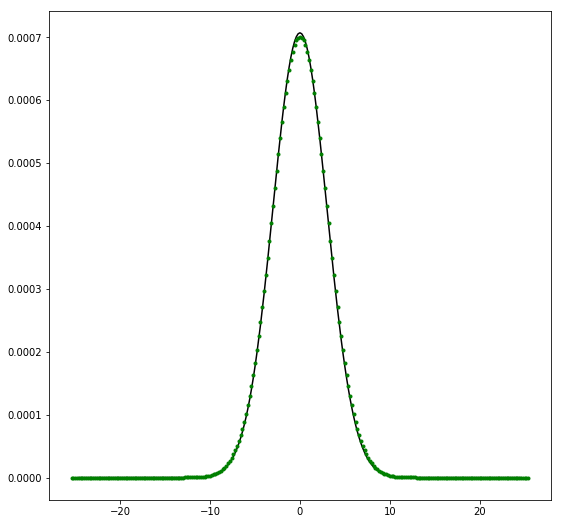

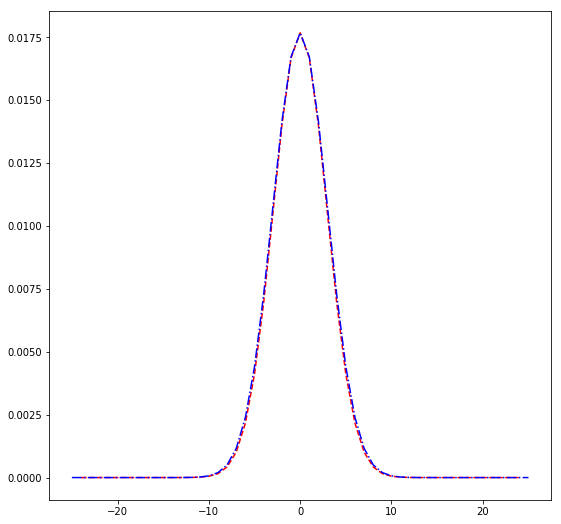

In [77]:
import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D

plt.figure(figsize = (9,9))
sigma = 3
y1, x1 = np.mgrid[0:50.6:0.2, 0:50.6:0.2] - 25.2
gm1 = Gaussian2D(100, 0, 0, sigma, sigma)
gs1 = gm1(x1, y1)
gs1 /= gs1.sum()

if(len(gs1)*0.2%1 > 0.5):
    ind = int((len(gs1)*0.2%1)//0.2)
    gs1 = gs1[ind:-ind,ind:-ind]
    print(len(gs1))
    x1 = x1[ind:-ind,ind:-ind]
    y1 = y1[ind:-ind,ind:-ind]

gs2 = resize_psf(gs1, 0.2, 1, order=3)
print(gs2.sum())
#gs2 /= gs2.sum()
y2, x2 = np.mgrid[0:len(gs2), 0:len(gs2)] - (len(gs2)-1)/2

y3, x3 = np.mgrid[0:51, 0:51] - 25
gm3 = Gaussian2D(100, 0, 0, sigma, sigma)
gs3 = gm3(x3, y3)
gs3 /= gs3.sum()

gs4 = resize_psf(gs3, 1, 0.2, order=3)
print(gs4.sum())
#gs4 /= gs4.sum()
y4, x4 = np.mgrid[0:len(gs4), 0:len(gs4)] - (len(gs4)-1)/2
print(len(x1),len(x2),len(x3),len(x4))

plt.plot(x1[123], gs1[123], 'k')
plt.plot(0.2*x4[125], gs4[125], 'g.')
plt.show()
plt.figure(figsize = (9,9))
plt.plot(x2[24], gs2[24], 'r--')
plt.plot(x3[25], gs3[25], 'b-.')
plt.show()

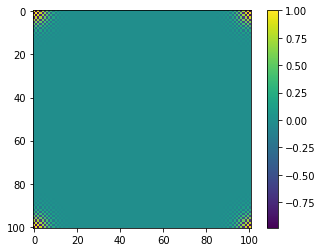

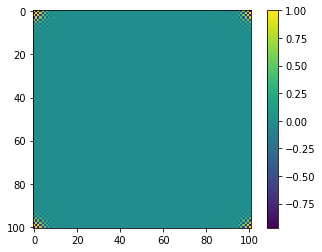

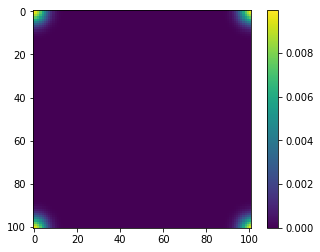

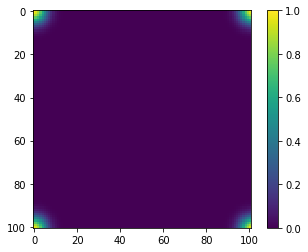

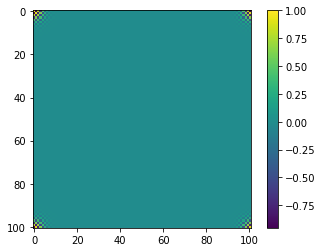

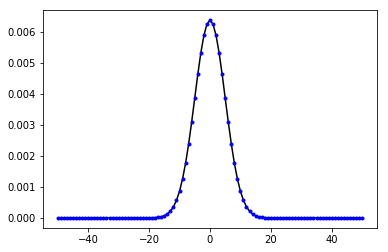

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.convolution import convolve
from astropy.convolution import convolve_fft
from numpy.fft import fft2, fftshift, ifft2, ifftshift, fftn, ifftn

#plt.figure(figsize = (9,9))
sigma1 = 3
sigma2 = 4
sigma3 = 5
y, x = np.mgrid[0:101, 0:101] - 50
gm1 = Gaussian2D(100, 0, 0, sigma1, sigma1)
gs1 = gm1(x, y)
gs1 /= gs1.sum()

gm2 = Gaussian2D(100, 0, 0, sigma2, sigma2)
gs2 = gm2(x, y)
gs2 /= gs2.sum()

gm3 = Gaussian2D(100, 0, 0, sigma3, sigma3)
gs3 = gm3(x, y)
gs3 /= gs3.sum()

ftg1 = fftn(gs1)
ftg2 = fftn(ifftshift(gs2))
multi = ftg1 * ftg2
rifft = ifftn(multi)
img = rifft.real
img1 =  convolve_fft(gs1, gs2, boundary = 'wrap', fft_pad=False, psf_pad=False)
img2 =  convolve(gs1, gs2, boundary = 'wrap',)

plt.imshow(ftg1.real)
plt.colorbar()
plt.show()
plt.imshow(fftn(gs2).real)
plt.colorbar()
plt.show()
plt.imshow(ifftshift(gs2))
plt.colorbar()
plt.show()
plt.imshow(ftg2.real)
plt.colorbar()
plt.show()
plt.imshow(multi.real)
plt.colorbar()
plt.show()
plt.plot(x[50],gs3[50], 'k-')
plt.plot(x[50],img[50], 'b.')
plt.show()

In [9]:
import warnings

import numpy as np
from functools import partial

from astropy.convolution.core import Kernel, Kernel1D, Kernel2D, MAX_NORMALIZATION
from astropy.utils.exceptions import AstropyUserWarning
from astropy.utils.console import human_file_size
from astropy.utils.decorators import deprecated_renamed_argument
from astropy import units as u
from astropy.nddata import support_nddata
from astropy.modeling.core import _make_arithmetic_operator, BINARY_OPERATORS
from astropy.modeling.core import _CompoundModelMeta
def convolve_fftt(array, kernel, boundary='fill', fill_value=0.,
                 nan_treatment='interpolate', normalize_kernel=True,
                 normalization_zero_tol=1e-8,
                 preserve_nan=False, mask=None, crop=True, return_fft=False,
                 fft_pad=None, psf_pad=None, quiet=False,
                 min_wt=0.0, allow_huge=False,
                 fftn=np.fft.fftn, ifftn=np.fft.ifftn,
                 complex_dtype=complex):
#    array = np.asarray(array, dtype=complex)
#    kernel = np.asarray(kernel, dtype=complex)
#    kernel_scale = kernel.sum()
#    normalized_kernel = kernel / kernel_scale
#    kernel_scale = 1
#    arrayfft = fftn(array)
#    kernfft = fftn(np.fft.ifftshift(kernel))
#    fftmult = arrayfft * kernfft
#    fftmult *= kernel_scale
#    rifft = ifftn(fftmult)
#    result = rifft.real
    return #result

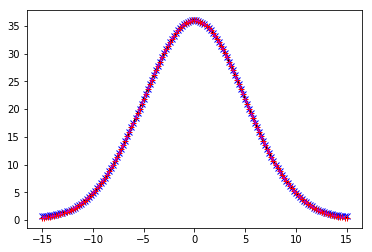

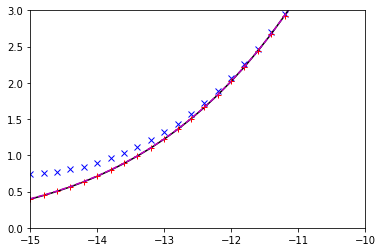

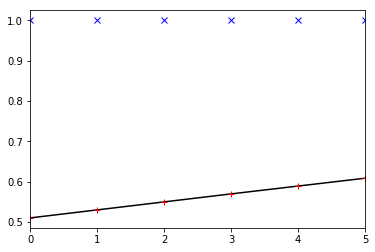

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.convolution import convolve
from astropy.convolution import convolve_fft
from numpy.fft import fft2, fftshift, ifft2, ifftshift, fftn, ifftn

sigma1 = 3
sigma2 = 4
sigma3 = 5
y, x = np.mgrid[0:30.2:0.2, 0:30.2:0.2] - 15
gm1 = Gaussian2D(100, 0, 0, sigma1, sigma1)
gs1 = gm1(x, y)

gm2 = Gaussian2D(100, 0, 0, sigma2, sigma2)
gs2 = gm2(x, y)

gm3 = Gaussian2D(100, 0, 0, sigma3, sigma3)
gs3 = gm3(x, y)

gs4 = np.ones((151,151))

array = np.asarray(gs1, dtype=complex)
kernel = np.asarray(gs2, dtype=complex)
kernel_scale = kernel.sum()
normalized_kernel = kernel / kernel_scale
kernel = normalized_kernel
kernel_scale = 1
arrayfft = fftn(array)
kernfft = fftn(ifftshift(kernel))
fftmult = arrayfft * kernfft
fftmult *= kernel_scale
rifft = ifftn(fftmult)
img = rifft.real
#img = convolve_fftt(gs1, gs2, boundary = 'wrap', nan_treatment='fill', fft_pad=False, psf_pad=False)
img1 =  convolve_fft(gs1, gs2, boundary = 'wrap')#, fft_pad=False, psf_pad=False)
img2 =  convolve(gs1, gs2, boundary = 'wrap',)

plt.plot(x[75],img[75], 'bx')
plt.plot(x[75],img1[75], 'k-')
plt.plot(x[75],img2[75], 'r+')
plt.plot(x[75],gs3[75]*(img1.max()/gs3.max()), 'm--')
plt.show()

plt.plot(x[75],img[75], 'bx')
plt.plot(x[75],img1[75], 'k-')
plt.plot(x[75],img2[75], 'r+')
plt.plot(x[75],gs3[75]*(img1.max()/gs3.max()), 'm--')
plt.xlim(-15,-10)
plt.ylim(0,3)
plt.show()

array = np.asarray(gs4, dtype=complex)
kernel = np.asarray(gs2, dtype=complex)
kernel_scale = kernel.sum()
normalized_kernel = kernel / kernel_scale
kernel = normalized_kernel
kernel_scale = 1
arrayfft = fftn(array)
kernfft = fftn(ifftshift(kernel))
fftmult = arrayfft * kernfft
fftmult *= kernel_scale
rifft = ifftn(fftmult)
img = rifft.real
img1 =  convolve_fft(gs4, gs2, boundary = 'wrap')
img2 =  convolve(gs4, gs2, boundary = 'wrap')

plt.plot(img[75], 'bx')
plt.plot(img1[75], 'k-')
plt.plot(img2[75], 'r+')
plt.xlim(0,5)
plt.show()

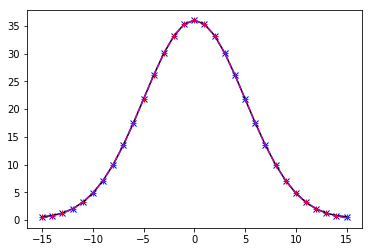

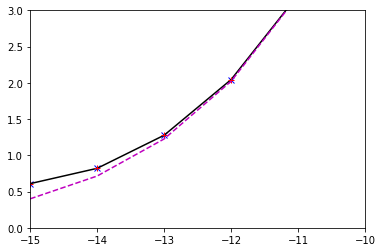

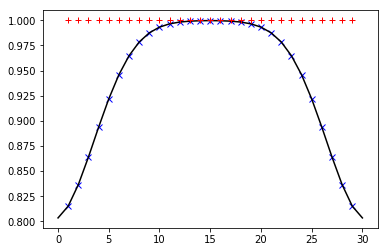

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.convolution import convolve
from astropy.convolution import convolve_fft
from numpy.fft import fft2, fftshift, ifft2, ifftshift, fftn, ifftn

sigma1 = 3
sigma2 = 4
sigma3 = 5
y, x = np.mgrid[0:31, 0:31] - 15
gm1 = Gaussian2D(100, 0, 0, sigma1, sigma1)
gs1 = gm1(x, y)

gm2 = Gaussian2D(100, 0, 0, sigma2, sigma2)
gs2 = gm2(x, y)

gm3 = Gaussian2D(100, 0, 0, sigma3, sigma3)
gs3 = gm3(x, y)

gs4 = np.ones((29,29))
gs5 = np.zeros((31,31))
gs5[1:30,1:30] = gs4

array = np.asarray(gs1, dtype=complex)
kernel = np.asarray(gs2, dtype=complex)
kernel_scale = kernel.sum()
normalized_kernel = kernel / kernel_scale
kernel = normalized_kernel
kernel_scale = 1
arrayfft = fftn(array)
kernfft = fftn(ifftshift(kernel))
fftmult = arrayfft * kernfft
fftmult *= kernel_scale
rifft = ifftn(fftmult)
img = rifft.real
#img = convolve_fftt(gs1, gs2, boundary = 'wrap', nan_treatment='fill', fft_pad=False, psf_pad=False)
img1 =  convolve_fft(gs1, gs2, boundary = 'wrap')#, fft_pad=False, psf_pad=False)
img2 =  convolve(gs1, gs2, boundary = 'wrap',)

plt.plot(x[15],img[15], 'bx')
plt.plot(x[15],img1[15], 'k-')
plt.plot(x[15],img2[15], 'r+')
plt.plot(x[15],gs3[15]*(img1.max()/gs3.max()), 'm--')
plt.show()

plt.plot(x[15],img[15], 'bx')
plt.plot(x[15],img1[15], 'k-')
plt.plot(x[15],img2[15], 'r+')
plt.plot(x[15],gs3[15]*(img1.max()/gs3.max()), 'm--')
plt.xlim(-15,-10)
plt.ylim(0,3)
plt.show()

#array = np.asarray(gs4, dtype=complex)
#kernel = np.asarray(gs2, dtype=complex)
#kernel_scale = kernel.sum()
#normalized_kernel = kernel / kernel_scale
#kernel = normalized_kernel
#kernel_scale = 1
#arrayfft = fftn(array)
#kernfft = fftn(ifftshift(kernel))
#fftmult = arrayfft * kernfft
#fftmult *= kernel_scale
#rifft = ifftn(fftmult)
#img = rifft.real
img = convolve_fft(gs4, gs2, boundary = 'wrap',)
img1 =  convolve_fft(gs5, gs2, boundary = 'wrap')
img2 =  convolve(gs4, gs2, boundary = 'wrap', )
x = np.arange(0,len(img1))
plt.plot(x[1:-1], img[14], 'bx')
plt.plot(x, img1[15], 'k-')
plt.plot(x[1:-1], img2[15], 'r+')
#plt.xlim(0,5)
plt.show()

In [191]:
sigma = 3
y, x = np.mgrid[0:21, 0:21] - 10
gm1 = Gaussian2D(100, 0, 0, sigma, sigma)
a = gm1(x, y)
a /= a.sum()
a = np.ones((7,7))
k = np.array([[1,2,1,5,6,5,6],[1,3,5,5,5,6,5],[1,1,5,6,5,6,6],[1,5,6,1,5,6,5],[1,3,5,1,5,6,5],[1,3,5,1,5,6,5],[1,3,5,1,5,6,5]])
#k = a#np.array([[1,1,3],[1,5,1],[1,2,1]])
h = np.zeros((len(a),len(a)))
for ii in range(0,len(a)):
    for jj in range(0,len(a)):
        for aa in range(-int((len(k)-1)/2),int((len(k)-1)/2)+1):
        #for aa in range(0,len(k)):
            for bb in range(-int((len(k)-1)/2),int((len(k)-1)/2)+1):
            #for bb in range(0,len(k)):
                if(ii-aa>=0 and ii-aa<len(a) and jj-bb >=0 and jj-bb<len(a)):
                    h[ii,jj] = h[ii,jj] + k[aa+int((len(k)-1)/2),bb+int((len(k)-1)/2)]*a[ii-aa,jj-bb]
h = h/k.sum()
#c = convolve(a, k, boundary = 'fill')
c = convolve_fft(a, k, boundary = 'fill')#, fft_pad=False, psf_pad=False)
#ftg1 = fftshift(fft2(a))
#ftg2 = fftshift(fft2(gs2))
#multi = ftg1 * ftg2
#image_covl = np.real(fftshift((ifft2(ifftshift(multi)))))

print(a)
print(k)
print(c)
print(h)
print(c/h)

[[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
[[1 2 1 5 6 5 6]
 [1 3 5 5 5 6 5]
 [1 1 5 6 5 6 6]
 [1 5 6 1 5 6 5]
 [1 3 5 1 5 6 5]
 [1 3 5 1 5 6 5]
 [1 3 5 1 5 6 5]]
[[0.25388601 0.3626943  0.48186528 0.59585492 0.57512953 0.51813472
  0.43005181]
 [0.30569948 0.44041451 0.59067358 0.73056995 0.70466321 0.63212435
  0.51813472]
 [0.35751295 0.51813472 0.69948187 0.86528497 0.83419689 0.74611399
  0.60621762]
 [0.40932642 0.59585492 0.80829016 1.         0.96373057 0.86010363
  0.69430052]
 [0.3626943  0.51813472 0.70466321 0.86528497 0.83419689 0.74093264
  0.58031088]
 [0.29015544 0.41968912 0.57512953 0.70984456 0.68393782 0.60621762
  0.47150259]
 [0.22279793 0.32642487 0.4507772  0.55440415 0.53367876 0.4611399
  0.35233161]]
[[0.25388601 0.3626943  0.48186528 0.59585492 0.57512953 0.51813472
  0.43005181]
 [0.30569948 0.44041451 0.59067358 0.73056995 0.7046632

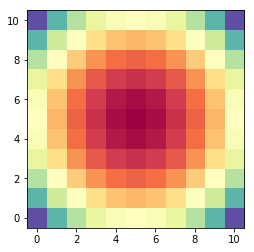

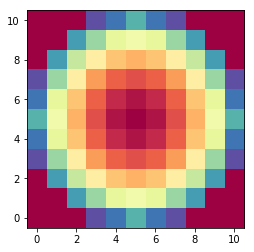

In [71]:
import numpy as np
from scipy.ndimage import rotate

x,y = np.mgrid[0:11, 0:11] - 5
c = x**2+y**2
plt.imshow(c, cmap='Spectral', origin='lower')
plt.show()
rotate(c, 45, axes=(1, 0), reshape=False, output=c)
plt.imshow(c, cmap='Spectral', origin='lower')
plt.show()